In [3]:

!git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git
%cd workshop-chihuahua-vs-muffin
!ls

Cloning into 'workshop-chihuahua-vs-muffin'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 337 (delta 1), reused 4 (delta 1), pack-reused 330 (from 1)
Receiving objects: 100% (337/337), 14.51 MiB | 25.53 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/workshop-chihuahua-vs-muffin
'CNN_1 Chihuahua or Muffin.ipynb'   README.md   workshop_1.ipynb
 data				    resources   workshop_1_output.ipynb


# Chihuahua vs Muffin Classifier using Convolutional Neural Networks

# 1. Introduction

In this lab, we'll build upon our previous workshop where we used a traditional Neural Network (NN) to classify images as either Chihuahuas or muffins. This time, we'll use a Convolutional Neural Network (CNN), which is particularly well-suited for image classification tasks because it can learn spatial hierarchies of features directly from the image data.
By the end of this lab, we'll compare the performance of our CNN model with the traditional NN from the previous workshop.

This is what we'll do in this lab:
#### 1) Build the  convolutional neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

Let's get started!

# 2.  Setup and Imports

Let's get to the fun stuff!
First, we need to Install and  import the necessary libraries. Each import serves a specific purpose in our project.
python


In [4]:
!pip install torch --upgrade
!pip install torchvision --upgrade

In [5]:
import numpy as np                          # Numpy for matrix operations
import torch                                 # PyTorch deep learning framework
import torch.nn as nn                        # Neural network module of PyTorch
import torch.optim as optim                  # Optimization algorithms
from torchvision import datasets, transforms # Tools for loading and transforming image data
from torch.utils.data import DataLoader      # Efficient data loading
import matplotlib.pyplot as plt              # For plotting and visualization. It is graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline
from tqdm import tqdm                        # For progress bars during training

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# 3 Data Preparation
Before we start training our model, it's crucial to separate our data into training and testing (validation) sets. This separation is a fundamental concept in machine learning that helps us assess how well our model generalizes to unseen data.

## 3.1 Understanding Train-Test Split
In machine learning, we typically divide our dataset into two main subsets:

1. **Training set:** This is the larger portion of the data that we use to train our model. The model learns the patterns and features from this data.
2. **Testing set** (also called Validation set): This is a smaller portion of the data that we set aside and don't use during training. We use this to evaluate how well our model performs on unseen data.

The reason for this split is to simulate how our model would perform on new, unseen data in the real world. If we tested on the same data we used for training, we wouldn't know if our model was truly learning general patterns or just memorizing the training data (a problem called overfitting).



In [7]:
import os

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

# Count the number of images in each set
train_chihuahuas = len(os.listdir("data/train/chihuahua"))
train_muffins = len(os.listdir("data/train/muffin"))
val_chihuahuas = len(os.listdir("data/validation/chihuahua"))
val_muffins = len(os.listdir("data/validation/muffin"))

print(f"Training set: {train_chihuahuas} Chihuahuas, {train_muffins} Muffins")
print(f"Validation set: {val_chihuahuas} Chihuahuas, {val_muffins} Muffins")

Data contents: ['validation', 'train']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']
Training set: 65 Chihuahuas, 55 Muffins
Validation set: 17 Chihuahuas, 13 Muffins



## 3.2 Dataset Structure
In our case, we've already separated our data into train and validation sets in our file structure:
You should see that we have two main directories (same dataset as previous exercise): 'train' and 'validation', each containing subdirectories for our classes (Chihuahua and Muffin).

## 3.3 Loading Separated Datasets
Now, let's load our separated datasets:
Remember we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

## 3.4 Define Data transformations
Now that we understand our dataset, let's define the transformations we'll apply to our images. These transformations help in data augmentation and normalization.
**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.


In [33]:
from torchvision import transforms
#  Define image dimensions
input_height, input_width = 224, 224

# Define data transforms for training and validation sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomRotation(10),  # Randomly rotate images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ]),
    'validation': transforms.Compose([
        transforms.Resize((input_height, input_width)),  # Resize images
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
    ])
}

## 3.5 Create Dataset and Dataloader
With our transformations defined, we can now create our datasets and dataloaders. These will efficiently feed data into our model during training.

In [34]:
# Load datasets
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'])
}

# Create dataloaders
batch_size = 224
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=2)
}

# Get the number of classes
num_classes = len(image_datasets['train'].classes)
print(f"Number of classes: {num_classes}")

# Print dataset sizes
print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['validation'])}")

Number of classes: 2
Training samples: 120
Validation samples: 30


### Let's break down what this code does:

1. We define separate data transforms for training and validation sets. The training set includes data augmentation (random flips and rotations) to increase variety in our training data, while the validation set doesn't use augmentation.

2. We use datasets.ImageFolder to load our images from the 'train' and 'validation' directories. This function automatically assigns labels based on the subdirectory names.

3. We create DataLoader objects for both sets. These handle batching our data and shuffling the training set (but not the validation set, as order doesn't matter for validation).

4. Finally, we print the sizes of our datasets to confirm the split.

By using separate dataloaders for training and validation, we ensure that our model is evaluated on data it hasn't seen during training, giving us a more accurate assessment of its performance.

# 4. Model Definition
Now that we've prepared our data, we can define our CNN model. We'll use the information about our input dimensions and number of classes to structure our network.

In [35]:
class ChihuahuaMuffinCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=num_classes):
        super(ChihuahuaMuffinCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional layer
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional layer
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth convolutional layer
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fifth convolutional layer
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * (input_height//32) * (input_width//32), 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through convolutional layers
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layers
        x = self.classifier(x)  # Pass through the fully connected layers
        return x

# Initialize the model and move it to the appropriate device
model = ChihuahuaMuffinCNN().to(device)
print(model)

# Print model summary
from torchsummary import summary
summary(model, (3, input_height, input_width))

ChihuahuaMuffinCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=25088, out

# 5. Training Setup
With our model defined, we now need to set up our loss function and optimizer. These are crucial components for training our network. In deep learning, they are the  two key components for training: Let's  recap and understand what these are and how we'll use them.

**Loss Function**
The loss function measures how well our model is performing. It calculates the difference between our model's predictions and the true labels. For our classification task, we'll use Cross Entropy Loss, which is well-suited for multi-class classification problems.

**Optimizer**
The optimizer is responsible for updating our model's parameters to minimize the loss function. We'll use the Adam optimizer, which is an extension of stochastic gradient descent (SGD) that adapts the learning rate for each parameter.

Let's define our loss function and optimizer:


In [36]:
# Define the loss function (Cross Entropy for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam) with learning rate 0.001
optimizer = optim.Adam(model.parameters(), lr=0.1)

print("Loss function:", criterion)
print("Optimizer:", optimizer)

Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.1
    maximize: False
    weight_decay: 0
)


### In this code:

nn.CrossEntropyLoss() creates our loss function.
optim.Adam(model.parameters(), lr=0.001) creates our optimizer. We pass it our model's parameters and set a learning rate of 0.001.

# 6. Model Trainning
Now we're ready to train our model. We'll define a function to handle the training process and then run it for a specified number of epochs.

This function will:
- Iterate over our data for a specified number of epochs

In each epoch, it will:
- Train on the training data
- Evaluate on the validation data

Keep track of and print our loss and accuracy for both training and validation sets
This will start the training process. You'll see progress bars for each epoch, along with loss and accuracy metrics for both training and validation sets.

The training process may take some time, depending on your hardware. Once it's complete, we'll have a trained model ready for making predictions!

In [37]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=120):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 120)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    return model

# Train the model
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=120)

print("Training complete!")

Epoch 1/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


train Loss: 0.6931 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


validation Loss: 197219120.0000 Acc: 0.5667

Epoch 2/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.32s/it]


train Loss: 367954016.0000 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


validation Loss: 6322911.0000 Acc: 0.4333

Epoch 3/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.00s/it]


train Loss: 6130957.5000 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


validation Loss: 414224352.0000 Acc: 0.4333

Epoch 4/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


train Loss: 352557760.0000 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 76151464.0000 Acc: 0.4333

Epoch 5/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


train Loss: 84507296.0000 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


validation Loss: 12468282.0000 Acc: 0.4333

Epoch 6/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.12s/it]


train Loss: 12187936.0000 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


validation Loss: 2793796.2500 Acc: 0.5667

Epoch 7/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.37s/it]


train Loss: 3539621.5000 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 62150612.0000 Acc: 0.4333

Epoch 8/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]


train Loss: 54839828.0000 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 5199887.5000 Acc: 0.5667

Epoch 9/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.60s/it]


train Loss: 6836877.0000 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


validation Loss: 2274579.7500 Acc: 0.5667

Epoch 10/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.64s/it]


train Loss: 2721561.2500 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 62610368.0000 Acc: 0.5667

Epoch 11/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.87s/it]


train Loss: 74901544.0000 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 3408226.7500 Acc: 0.5000

Epoch 12/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.77s/it]


train Loss: 12274442.0000 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 18636954.0000 Acc: 0.4333

Epoch 13/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.62s/it]


train Loss: 18093472.0000 Acc: 0.4833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


validation Loss: 15370463.0000 Acc: 0.5667

Epoch 14/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.63s/it]


train Loss: 16301854.0000 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 48907072.0000 Acc: 0.4333

Epoch 15/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.48s/it]


train Loss: 37908260.0000 Acc: 0.4500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 3634854.7500 Acc: 0.5667

Epoch 16/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.78s/it]


train Loss: 3958376.0000 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


validation Loss: 1778110.3750 Acc: 0.4667

Epoch 17/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.55s/it]


train Loss: 1860991.2500 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


validation Loss: 736515.5625 Acc: 0.7000

Epoch 18/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.31s/it]


train Loss: 1897643.1250 Acc: 0.6167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


validation Loss: 1252288.3750 Acc: 0.7333

Epoch 19/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.90s/it]


train Loss: 1706187.6250 Acc: 0.7167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


validation Loss: 2029995.2500 Acc: 0.6333

Epoch 20/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.45s/it]


train Loss: 1772014.8750 Acc: 0.6750


validation: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


validation Loss: 1433384.7500 Acc: 0.6000

Epoch 21/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.83s/it]


train Loss: 2915875.2500 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


validation Loss: 383771.4375 Acc: 0.5667

Epoch 22/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.56s/it]


train Loss: 576505.4375 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


validation Loss: 75552.2891 Acc: 0.5667

Epoch 23/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.80s/it]


train Loss: 152093.9375 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


validation Loss: 35778.9570 Acc: 0.5667

Epoch 24/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.01s/it]


train Loss: 5977.8760 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


validation Loss: 13253.7705 Acc: 0.5667

Epoch 25/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.99s/it]


train Loss: 762.5391 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


validation Loss: 3.5311 Acc: 0.5667

Epoch 26/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.14s/it]


train Loss: 4780.1587 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 1.6605 Acc: 0.5667

Epoch 27/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.04s/it]


train Loss: 6833.9609 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.6675 Acc: 0.5667

Epoch 28/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 23.00s/it]


train Loss: 0.9357 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 1.4480 Acc: 0.4667

Epoch 29/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.99s/it]


train Loss: 1.3710 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 2.2168 Acc: 0.4333

Epoch 30/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.36s/it]


train Loss: 2.0437 Acc: 0.4667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 21138.6309 Acc: 0.4333

Epoch 31/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.43s/it]


train Loss: 5833.4253 Acc: 0.4750


validation: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


validation Loss: 2.2319 Acc: 0.4333

Epoch 32/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.78s/it]


train Loss: 2.1109 Acc: 0.4500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 1.7936 Acc: 0.4333

Epoch 33/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.63s/it]


train Loss: 1714.0994 Acc: 0.4500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 1.1553 Acc: 0.4333

Epoch 34/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.38s/it]


train Loss: 1.2311 Acc: 0.4250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


validation Loss: 0.7391 Acc: 0.4333

Epoch 35/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.57s/it]


train Loss: 0.9215 Acc: 0.4917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


validation Loss: 0.7566 Acc: 0.5667

Epoch 36/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.70s/it]


train Loss: 0.9201 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.9733 Acc: 0.5667

Epoch 37/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.31s/it]


train Loss: 1.0476 Acc: 0.5750


validation: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


validation Loss: 1.0551 Acc: 0.5667

Epoch 38/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.82s/it]


train Loss: 1.1523 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.14s/it]


validation Loss: 0.9150 Acc: 0.5667

Epoch 39/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.53s/it]


train Loss: 1.1523 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


validation Loss: 0.7263 Acc: 0.5667

Epoch 40/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.78s/it]


train Loss: 0.9758 Acc: 0.4917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


validation Loss: 0.7203 Acc: 0.4333

Epoch 41/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


train Loss: 1.0249 Acc: 0.4417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


validation Loss: 0.7987 Acc: 0.4333

Epoch 42/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.31s/it]


train Loss: 1.0226 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.7372 Acc: 0.4333

Epoch 43/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.51s/it]


train Loss: 0.9921 Acc: 0.5667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 44/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.28s/it]


train Loss: 0.9012 Acc: 0.5667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


validation Loss: 0.7223 Acc: 0.5667

Epoch 45/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.56s/it]


train Loss: 0.8928 Acc: 0.5583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


validation Loss: 0.7479 Acc: 0.5667

Epoch 46/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


train Loss: 1.0499 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.7201 Acc: 0.5667

Epoch 47/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.05s/it]


train Loss: 0.8861 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6884 Acc: 0.5667

Epoch 48/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.60s/it]


train Loss: 0.8227 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


validation Loss: 0.6877 Acc: 0.5667

Epoch 49/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.08s/it]


train Loss: 0.8104 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:03<00:00,  3.33s/it]


validation Loss: 0.7004 Acc: 0.4333

Epoch 50/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.67s/it]


train Loss: 0.9444 Acc: 0.4750


validation: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


validation Loss: 0.6895 Acc: 0.5667

Epoch 51/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.07s/it]


train Loss: 0.9671 Acc: 0.4667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 52/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.84s/it]


train Loss: 0.7411 Acc: 0.5583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6894 Acc: 0.5667

Epoch 53/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.97s/it]


train Loss: 0.8336 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


validation Loss: 0.6933 Acc: 0.5667

Epoch 54/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.16s/it]


train Loss: 0.8124 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.6847 Acc: 0.5667

Epoch 55/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.49s/it]


train Loss: 0.7905 Acc: 0.4750


validation: 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]


validation Loss: 0.6913 Acc: 0.5667

Epoch 56/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:35<00:00, 35.20s/it]


train Loss: 0.7842 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


validation Loss: 0.6929 Acc: 0.5667

Epoch 57/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.60s/it]


train Loss: 0.7944 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6875 Acc: 0.5667

Epoch 58/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.29s/it]


train Loss: 0.7693 Acc: 0.4917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6842 Acc: 0.5667

Epoch 59/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.28s/it]


train Loss: 0.7639 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


validation Loss: 0.6851 Acc: 0.5667

Epoch 60/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.68s/it]


train Loss: 0.7688 Acc: 0.4750


validation: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]


validation Loss: 0.6880 Acc: 0.5667

Epoch 61/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.53s/it]


train Loss: 0.7556 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


validation Loss: 0.6854 Acc: 0.5667

Epoch 62/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.27s/it]


train Loss: 0.6807 Acc: 0.5667


validation: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 63/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.88s/it]


train Loss: 0.7500 Acc: 0.4583


validation: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]


validation Loss: 0.6844 Acc: 0.5667

Epoch 64/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.36s/it]


train Loss: 0.7209 Acc: 0.4833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


validation Loss: 0.6870 Acc: 0.5667

Epoch 65/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.98s/it]


train Loss: 0.7135 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6899 Acc: 0.5667

Epoch 66/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.03s/it]


train Loss: 0.7540 Acc: 0.3917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


validation Loss: 0.6867 Acc: 0.5667

Epoch 67/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


train Loss: 0.7101 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 68/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.35s/it]


train Loss: 0.6924 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


validation Loss: 0.6842 Acc: 0.5667

Epoch 69/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.08s/it]


train Loss: 0.6962 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


validation Loss: 0.6842 Acc: 0.5667

Epoch 70/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


train Loss: 0.7070 Acc: 0.4917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


validation Loss: 0.6846 Acc: 0.5667

Epoch 71/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.68s/it]


train Loss: 0.7144 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 0.6850 Acc: 0.5667

Epoch 72/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.64s/it]


train Loss: 361.3002 Acc: 0.4917


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6853 Acc: 0.5667

Epoch 73/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.61s/it]


train Loss: 0.6956 Acc: 0.5750


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6859 Acc: 0.5667

Epoch 74/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.36s/it]


train Loss: 0.6862 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


validation Loss: 0.6856 Acc: 0.5667

Epoch 75/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.81s/it]


train Loss: 0.6995 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.6855 Acc: 0.5667

Epoch 76/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.54s/it]


train Loss: 0.7075 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


validation Loss: 0.6854 Acc: 0.5667

Epoch 77/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.27s/it]


train Loss: 0.6851 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


validation Loss: 0.6852 Acc: 0.5667

Epoch 78/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:31<00:00, 31.88s/it]


train Loss: 0.7155 Acc: 0.4833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6849 Acc: 0.5667

Epoch 79/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:25<00:00, 25.10s/it]


train Loss: 0.7045 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 0.6846 Acc: 0.5667

Epoch 80/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.44s/it]


train Loss: 0.6913 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 81/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.07s/it]


train Loss: 0.6869 Acc: 0.5667


validation: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


validation Loss: 0.6849 Acc: 0.5667

Epoch 82/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.41s/it]


train Loss: 0.6994 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 83/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.75s/it]


train Loss: 0.6810 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]


validation Loss: 0.6893 Acc: 0.5667

Epoch 84/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.30s/it]


train Loss: 0.7196 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]


validation Loss: 0.6853 Acc: 0.5667

Epoch 85/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.60s/it]


train Loss: 0.6663 Acc: 0.6167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


validation Loss: 0.6867 Acc: 0.5667

Epoch 86/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.45s/it]


train Loss: 0.6947 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6845 Acc: 0.5667

Epoch 87/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.50s/it]


train Loss: 0.7369 Acc: 0.4833


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.6916 Acc: 0.5667

Epoch 88/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.26s/it]


train Loss: 0.7126 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


validation Loss: 0.7128 Acc: 0.4333

Epoch 89/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.07s/it]


train Loss: 0.6976 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


validation Loss: 0.7072 Acc: 0.4333

Epoch 90/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.40s/it]


train Loss: 0.7021 Acc: 0.4417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


validation Loss: 0.6966 Acc: 0.4333

Epoch 91/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.88s/it]


train Loss: 0.7398 Acc: 0.4083


validation: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


validation Loss: 0.6873 Acc: 0.5667

Epoch 92/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.49s/it]


train Loss: 0.6974 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 93/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.26s/it]


train Loss: 0.7044 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]


validation Loss: 0.6855 Acc: 0.5667

Epoch 94/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.05s/it]


train Loss: 0.6996 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


validation Loss: 0.6879 Acc: 0.5667

Epoch 95/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.52s/it]


train Loss: 0.7025 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]


validation Loss: 0.6893 Acc: 0.5667

Epoch 96/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.57s/it]


train Loss: 0.7058 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6889 Acc: 0.5667

Epoch 97/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.56s/it]


train Loss: 0.7064 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


validation Loss: 0.6871 Acc: 0.5667

Epoch 98/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]


train Loss: 0.6971 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.56s/it]


validation Loss: 0.6849 Acc: 0.5667

Epoch 99/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.16s/it]


train Loss: 0.6933 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 100/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.73s/it]


train Loss: 0.7016 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


validation Loss: 0.6857 Acc: 0.5667

Epoch 101/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:30<00:00, 30.51s/it]


train Loss: 0.6897 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


validation Loss: 0.6886 Acc: 0.5667

Epoch 102/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:24<00:00, 24.21s/it]


train Loss: 0.6929 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


validation Loss: 0.6918 Acc: 0.5667

Epoch 103/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.49s/it]


train Loss: 0.7135 Acc: 0.4417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


validation Loss: 0.6930 Acc: 0.5667

Epoch 104/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.41s/it]


train Loss: 0.7109 Acc: 0.4083


validation: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


validation Loss: 0.6918 Acc: 0.5667

Epoch 105/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.50s/it]


train Loss: 0.7209 Acc: 0.4250


validation: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it]


validation Loss: 0.6889 Acc: 0.5667

Epoch 106/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:22<00:00, 22.55s/it]


train Loss: 0.6802 Acc: 0.5333


validation: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


validation Loss: 0.6865 Acc: 0.5667

Epoch 107/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.24s/it]


train Loss: 0.6937 Acc: 0.5000


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.6850 Acc: 0.5667

Epoch 108/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.19s/it]


train Loss: 0.6996 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 109/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.96s/it]


train Loss: 0.6926 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 110/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.29s/it]


train Loss: 0.6786 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]


validation Loss: 0.6844 Acc: 0.5667

Epoch 111/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.20s/it]


train Loss: 0.6895 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


validation Loss: 0.6844 Acc: 0.5667

Epoch 112/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.67s/it]


train Loss: 0.6881 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


validation Loss: 0.6843 Acc: 0.5667

Epoch 113/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.65s/it]


train Loss: 0.6947 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it]


validation Loss: 0.6842 Acc: 0.5667

Epoch 114/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.47s/it]


train Loss: 0.6961 Acc: 0.5500


validation: 100%|██████████| 1/1 [00:02<00:00,  2.92s/it]


validation Loss: 0.6844 Acc: 0.5667

Epoch 115/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.19s/it]


train Loss: 0.6959 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


validation Loss: 0.6846 Acc: 0.5667

Epoch 116/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.19s/it]


train Loss: 0.7016 Acc: 0.5417


validation: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


validation Loss: 0.6849 Acc: 0.5667

Epoch 117/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.88s/it]


train Loss: 0.6941 Acc: 0.5083


validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


validation Loss: 0.6852 Acc: 0.5667

Epoch 118/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.18s/it]


train Loss: 0.6923 Acc: 0.5167


validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


validation Loss: 0.6854 Acc: 0.5667

Epoch 119/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.20s/it]


train Loss: 0.6976 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


validation Loss: 0.6853 Acc: 0.5667

Epoch 120/120
------------------------------------------------------------------------------------------------------------------------


train: 100%|██████████| 1/1 [00:23<00:00, 23.58s/it]


train Loss: 0.6898 Acc: 0.5250


validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]

validation Loss: 0.6852 Acc: 0.5667

Training complete!


 ###This function does the following:

1. For each epoch:
-  It trains the model on the training data.
-  It then evaluates the model on the validation data.
-  For both phases, it calculates and prints the average loss and accuracy.


2. The model.train() and model.eval() calls ensure the model behaves appropriately for training and validation phases.

3. We use torch.set_grad_enabled() to only calculate gradients during the training phase.

4. In the training phase, we perform backpropagation (loss.backward()) and update the model parameters (optimizer.step()).

# 7. Examine model performance (Model Evaluation)
Finally, let's evaluate our trained model on the validation set and visualize some of its predictions.

Validation Accuracy: 0.5667


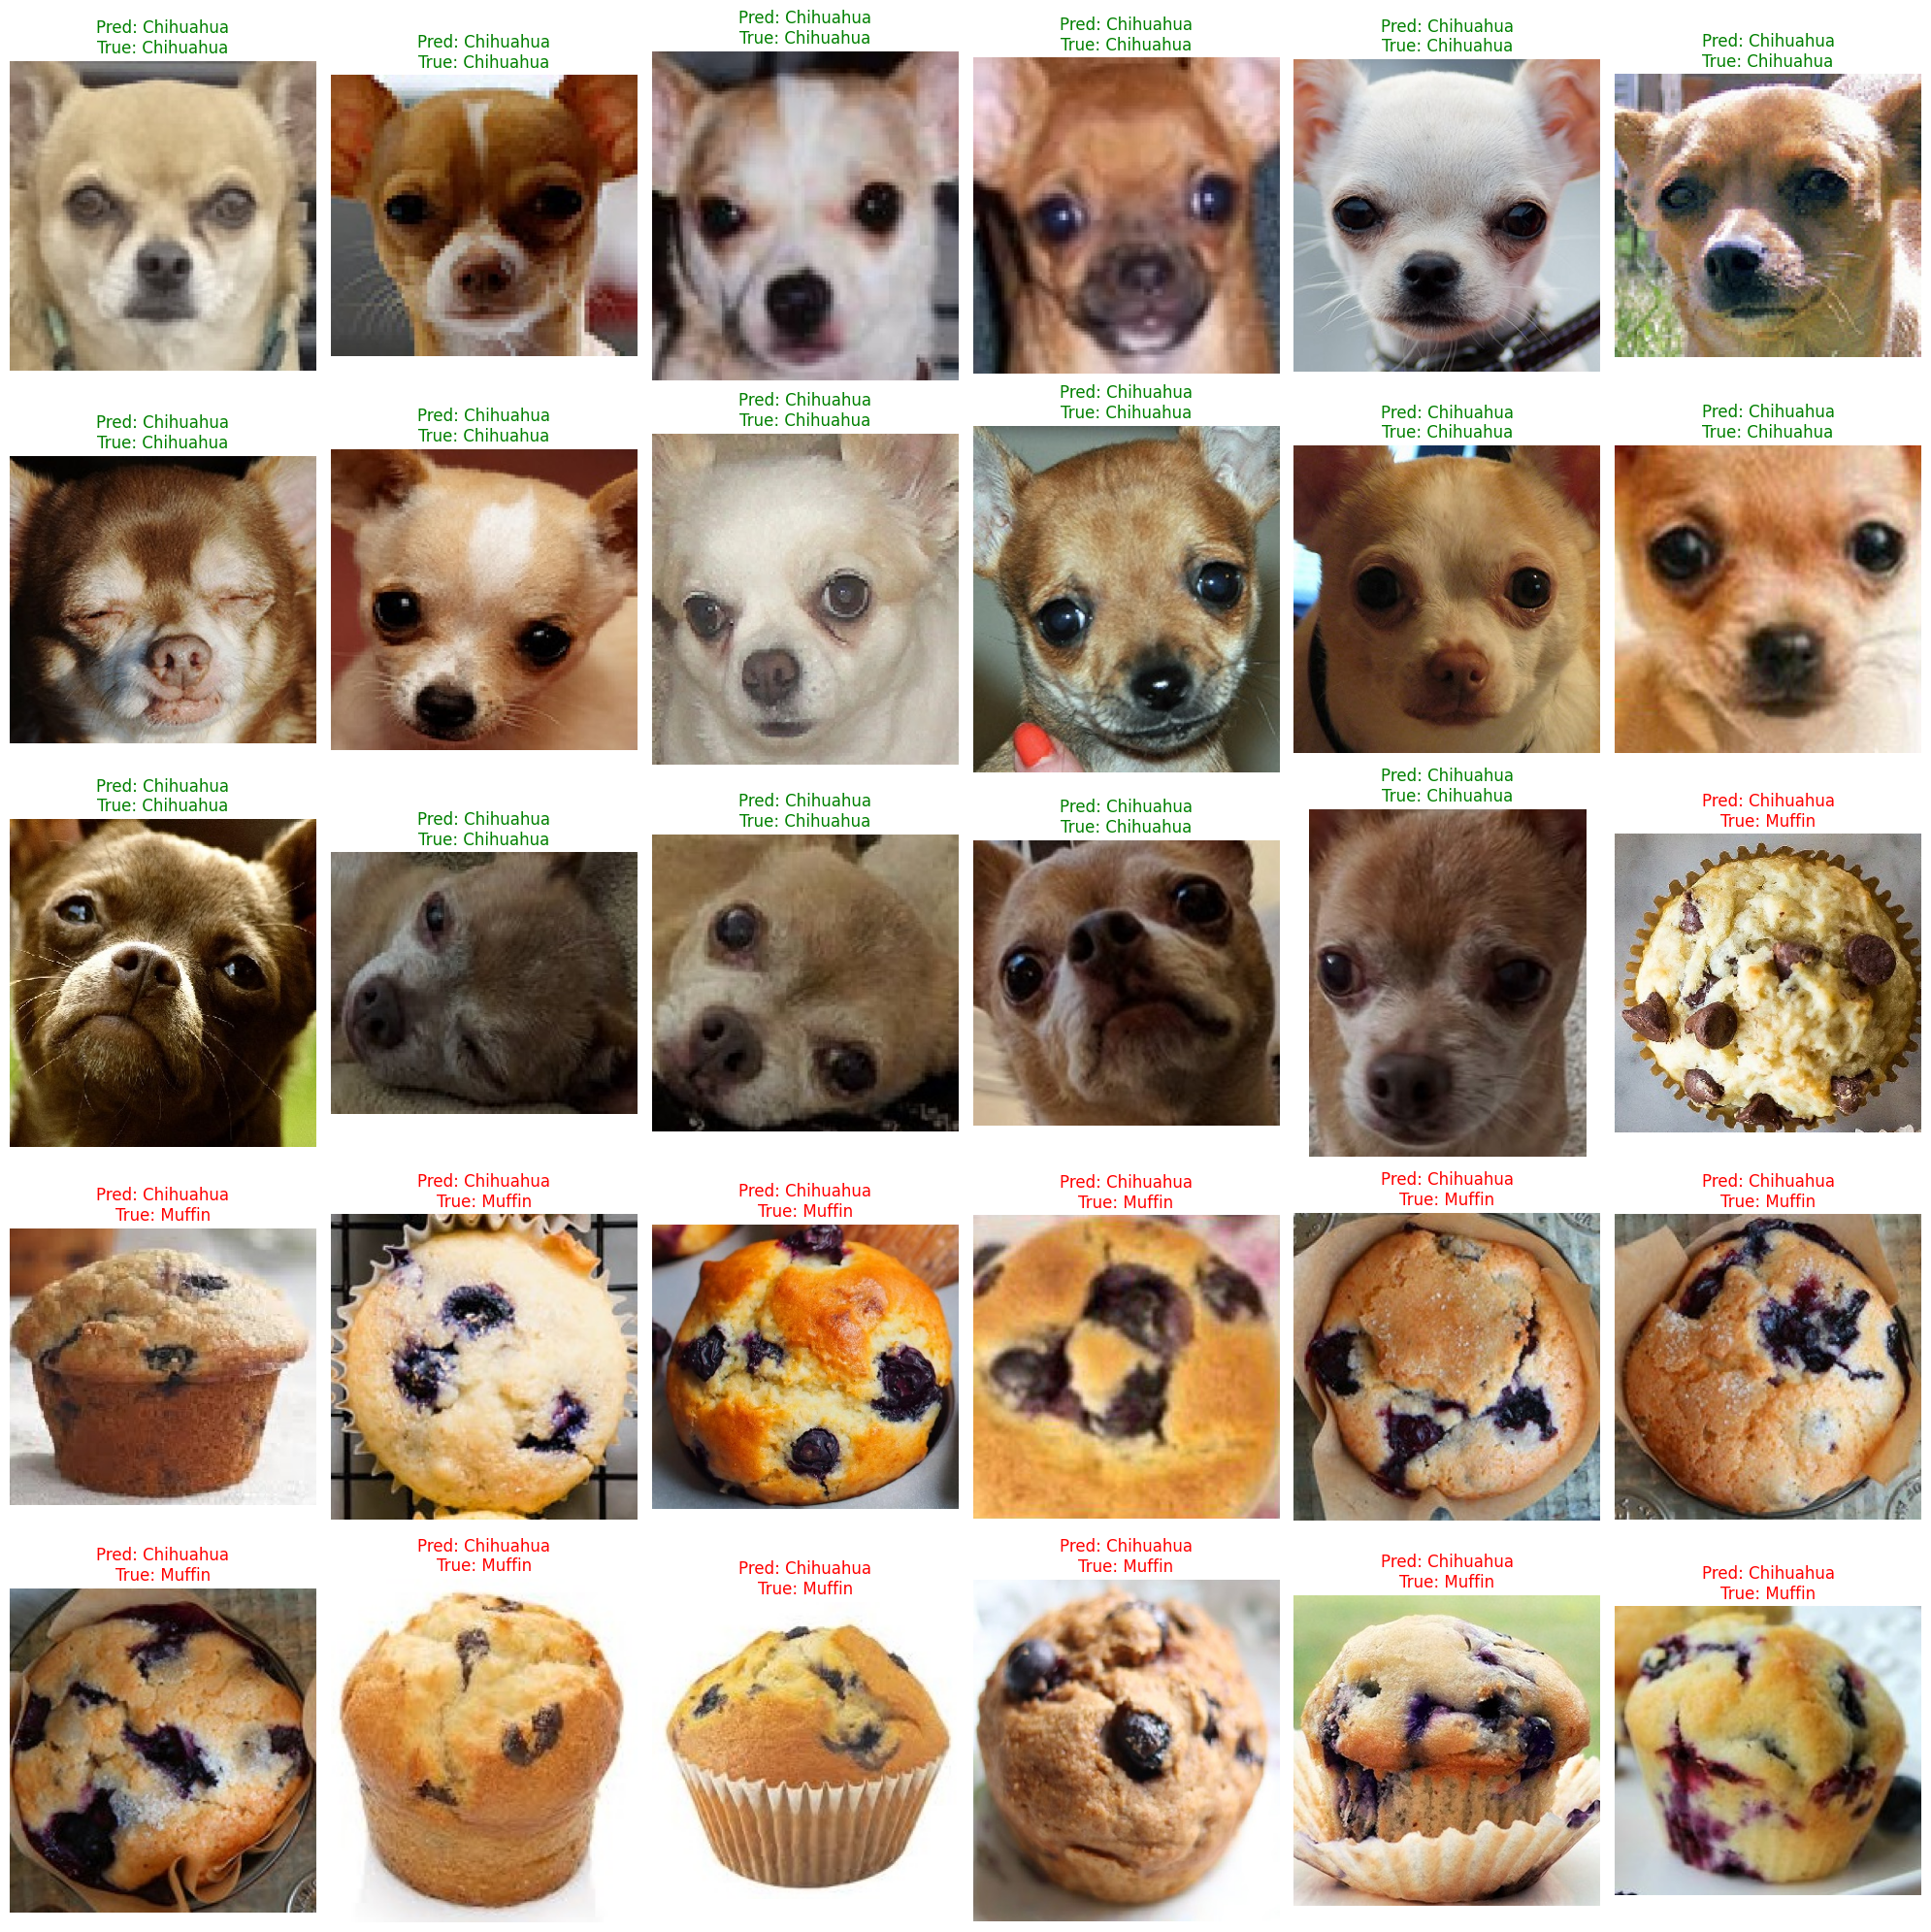

In [38]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    return all_preds, all_labels

# Get predictions
val_preds, val_labels = evaluate_model(trained_model, dataloaders['validation'])

# Calculate accuracy
accuracy = sum(np.array(val_preds) == np.array(val_labels)) / len(val_labels)
print(f"Validation Accuracy: {accuracy:.4f}")

# Visualize some predictions
def plot_results(images, preds, labels):
    fig, axs = plt.subplots(5, 6, figsize=(20, 20))
    for i, (img_path, pred, label) in enumerate(zip(image_datasets['validation'].imgs, preds, labels)):
        img = plt.imread(img_path[0])
        ax = axs[i // 6, i % 6]
        ax.imshow(img)
        ax.axis('off')
        color = 'green' if pred == label else 'red'
        ax.set_title(f"Pred: {'Chihuahua' if pred == 0 else 'Muffin'}\nTrue: {'Chihuahua' if label == 0 else 'Muffin'}", color=color)
    plt.tight_layout()
    plt.show()

plot_results(image_datasets['validation'].imgs, val_preds, val_labels)

# 8.  Conclusion and Reflection

Congratulations! You've successfully built, trained, and evaluated a CNN for classifying Chihuahuas and Muffins. Here are some reflection questions to consider:

How does the performance of this CNN compare to the traditional Neural Network from the previous workshop?
What role do the convolutional layers play in image classification?
How might you further improve this model's performance?
What challenges might this model face in real-world applications?
How does data augmentation (like random flips and rotations) contribute to the model's performance?
What are the ethical considerations in developing and deploying an image classification system like this?

Remember to support your answers with references to relevant literature or resources on deep learning and computer vision. Good luck with your reflective journal!

 If you want  you can play with some hyperparameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
I've modified it significantly to cater to this Lab.

The original tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.